# 1. Preparations

In [1]:
!pip install torchdata
!pip install portalocker>=2.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 1-1. Import Libraries




In [2]:
import os
import random
import time
import sys
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchtext import data, datasets
import time
import spacy
import numpy as np
from torch import Tensor
from torchtext.datasets import IMDB

In [3]:
import torchtext
torchtext.__version__

'0.15.2+cpu'

### 1-2. Load data
- IMDB 데이터를 다운받습니다.
- Train,valid,test 데이터셋으로 split 합니다.

In [4]:
#!pip install datasets

In [5]:
# from datasets import load_dataset
# imdb=load_dataset("imdb")

In [6]:
from torchtext.datasets import IMDB
train_iter, test_iter = IMDB(split=('train', 'test'))




*   split train data into 7:3 portion as train:valid



In [7]:
length = len(list(train_iter))
print(length)
valid_iter = list(train_iter)[int(0.7*length):]
train_iter = list(train_iter)[:int(0.7*length)]

25000


In [8]:
print(len(list(train_iter)))
print(len(list(valid_iter)))

17500
7500


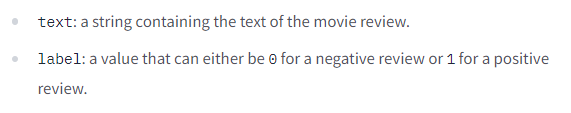

### 1-3. Building Vocabulary


*   Build the vocabulary directly with the Vocab class



In [96]:
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('basic_english')

In [97]:
from collections import Counter
from torchtext.vocab import vocab
from torchtext.datasets import IMDB
#train_iter = IMDB(split='train')
counter = Counter()
#for (label, line) in imdb['train']:
for (label, line) in train_iter:
    counter.update(tokenizer(line))
vocab = vocab(counter, min_freq=1, specials=('<unk>', '<BOS>', '<EOS>', '<PAD>'))
vocab.set_default_index(vocab['<unk>'])


In [98]:
print("The length of the new vocab is", len(vocab))
new_stoi = vocab.get_stoi()
print("The index of '<BOS>' is", new_stoi['<BOS>'])
new_itos = vocab.get_itos()
print("The token at index 2 is", new_itos[2])
print("The token at index 3 is", new_itos[3])
print("The token at index 100 is", new_itos[100])

The length of the new vocab is 100686
The index of '<BOS>' is 1
The token at index 2 is <EOS>
The token at index 3 is <PAD>
The token at index 100 is ordinary






*   Build Vocabulary using GloVe
(3분 정도 소요)




In [12]:
#from torchtext.vocab import GloVe, vocab

#glove_vectors = GloVe(name='6B', dim=100)
#glove_vocab = vocab(glove_vectors.stoi)
#vocab_byname = glove_vocab.get_stoi()
#vocab_byindex = glove_vocab.get_itos()

In [13]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}"'.format(name=fn))

Saving glove.6B.100d.zip to glove.6B.100d.zip
User uploaded file "glove.6B.100d.zip"


In [14]:
!unzip -qq "./glove.6B.100d.zip"

In [15]:
from torchtext.vocab import vocab, Vectors

class GloVe(Vectors):
    url = {
        "42B": "http://nlp.stanford.edu/data/glove.42B.300d.zip",
        "840B": "http://nlp.stanford.edu/data/glove.840B.300d.zip",
        "twitter.27B": "http://nlp.stanford.edu/data/glove.twitter.27B.zip",
        "6B": "/content/glove.6B.100d.zip",
    }
    def __init__(self, name="840B", dim=300, **kwargs) -> None:
        url = self.url[name]
        name = "glove.{}.{}d.txt".format(name, str(dim))
        super(GloVe, self).__init__(name, url=url, **kwargs)


In [16]:
glove_vectors = GloVe(name='6B', dim=100)

100%|█████████▉| 400000/400001 [00:22<00:00, 17945.72it/s]


In [17]:
unk_index = 0
bos_index = 1
eos_index = 2
pad_index = 3
glove_vectors = GloVe(name='6B', dim=100)
glove_vocab = vocab(glove_vectors.stoi)
glove_vocab.insert_token("<UNK>",unk_index)
glove_vocab.insert_token("<BOS>",bos_index)
glove_vocab.insert_token("<EOS>",eos_index)
glove_vocab.insert_token("<PAD>",pad_index)
vocab_byname = glove_vocab.get_stoi()
vocab_byindex = glove_vocab.get_itos()

pretrained_embeddings = glove_vectors.vectors
pretrained_embeddings = torch.cat((torch.zeros(4,pretrained_embeddings.shape[1]),pretrained_embeddings))

glove_vocab.set_default_index(unk_index)

vocab = glove_vocab.get_stoi()

In [18]:
print("The length of the new vocab is", len(pretrained_embeddings))
new_stoi = glove_vocab.get_stoi()
print("The index of '<UNK>' is", new_stoi['<UNK>'])
new_itos = glove_vocab.get_itos()
print("The token at index 2 is", new_itos[2])
print("The token at index 2100 is", new_itos[2100])
print("The token at index 210000 is", new_itos[78634])

The length of the new vocab is 400005
The index of '<UNK>' is 0
The token at index 2 is <EOS>
The token at index 2100 is stood
The token at index 210000 is canisius


In [19]:
print(glove_vectors.vectors[-1])
print(glove_vectors.vectors[100])
print(glove_vectors.vectors[0])

tensor([ 0.2837, -0.6263, -0.4435,  0.2177, -0.0874, -0.1706,  0.2927, -0.0249,
         0.2641, -0.1702,  0.2582,  0.0975, -0.3310, -0.4386,  0.0096,  0.0956,
        -0.1778,  0.3889,  0.2715,  0.1474, -0.4397, -0.2659, -0.0243,  0.2719,
        -0.3676, -0.2483, -0.2081,  0.2213, -0.0444,  0.0214,  0.2459,  0.2614,
         0.2930,  0.1328,  0.0822, -0.1287,  0.1622, -0.2257, -0.0603,  0.2870,
         0.1138,  0.3484,  0.3419,  0.3700, -0.1359,  0.0063,  0.0803,  0.0036,
         0.4309,  0.0188,  0.3101,  0.1672,  0.0741, -0.3774,  0.4736,  0.4128,
         0.2447,  0.0760, -0.5173, -0.4948,  0.5260, -0.0746,  0.4143, -0.1956,
        -0.1654, -0.0456, -0.4015, -0.1314, -0.4672,  0.1883,  0.2612,  0.1685,
         0.2262,  0.6299, -0.1288,  0.0558,  0.0193,  0.0246,  0.4688,  0.2582,
        -0.3167,  0.0486,  0.3277, -0.5014,  0.3086,  0.1200, -0.2577, -0.0399,
        -0.0597,  0.5525,  0.1389, -0.2286,  0.0718, -0.4321,  0.5398, -0.0858,
         0.0327,  0.4368, -0.8261, -0.15

In [21]:
print(pretrained_embeddings[-1])
print(pretrained_embeddings[103])
print(pretrained_embeddings[0])
print(pretrained_embeddings[4])

tensor([ 0.2837, -0.6263, -0.4435,  0.2177, -0.0874, -0.1706,  0.2927, -0.0249,
         0.2641, -0.1702,  0.2582,  0.0975, -0.3310, -0.4386,  0.0096,  0.0956,
        -0.1778,  0.3889,  0.2715,  0.1474, -0.4397, -0.2659, -0.0243,  0.2719,
        -0.3676, -0.2483, -0.2081,  0.2213, -0.0444,  0.0214,  0.2459,  0.2614,
         0.2930,  0.1328,  0.0822, -0.1287,  0.1622, -0.2257, -0.0603,  0.2870,
         0.1138,  0.3484,  0.3419,  0.3700, -0.1359,  0.0063,  0.0803,  0.0036,
         0.4309,  0.0188,  0.3101,  0.1672,  0.0741, -0.3774,  0.4736,  0.4128,
         0.2447,  0.0760, -0.5173, -0.4948,  0.5260, -0.0746,  0.4143, -0.1956,
        -0.1654, -0.0456, -0.4015, -0.1314, -0.4672,  0.1883,  0.2612,  0.1685,
         0.2262,  0.6299, -0.1288,  0.0558,  0.0193,  0.0246,  0.4688,  0.2582,
        -0.3167,  0.0486,  0.3277, -0.5014,  0.3086,  0.1200, -0.2577, -0.0399,
        -0.0597,  0.5525,  0.1389, -0.2286,  0.0718, -0.4321,  0.5398, -0.0858,
         0.0327,  0.4368, -0.8261, -0.15

In [72]:
text_transform = lambda x: [glove_vocab['<BOS>']] + [glove_vocab[token] for token in tokenizer(x)] + [glove_vocab['<EOS>']]
label_transform = lambda x: 1 if x == 2 else 0

# Print out the output of text_transform
print("input to the text_transform:", "here is an example")
print("output of the text_transform:", text_transform("here is an example"))

input to the text_transform: here is an example
output of the text_transform: [1, 190, 17, 32, 883, 2]


In [99]:
text_transform = lambda x: [vocab['<BOS>']] + [vocab[token] for token in tokenizer(x)] + [vocab['<EOS>']]
label_transform = lambda x: 1 if x == 2 else 0

# Print out the output of text_transform
print("input to the text_transform:", "here is an example")
print("output of the text_transform:", text_transform("here is an example"))

input to the text_transform: here is an example
output of the text_transform: [1, 1060, 56, 202, 3977, 2]


In [100]:
# Split train and valid data
#train_data, valid_data = train_data.split(random_state = random.seed(SEED))

### 1-3. Cuda Setup
- GPU 사용을 위한 Cuda 설정
- Colab 페이지 상단 메뉴>수정>노트설정에서 GPU 사용 설정이 선행되어야 합니다.


In [101]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda:0" if USE_CUDA else "cpu")

In [102]:
USE_CUDA

True

In [103]:
!nvidia-smi

Mon Jun 26 01:21:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    28W /  70W |  11613MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##2. Data Loader 선언


1.   batch기반의 딥러닝 학습을 위해 mini batch 형성
2.   dataset, batch size, shuffle, collate_fn



In [104]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
  label_list, text_list = [], []
  for (_label, _text) in batch:
      label_list.append(label_transform(_label))
      processed_text = torch.tensor(text_transform(_text))
      text_list.append(processed_text)
  return torch.tensor(label_list).to(device), pad_sequence(text_list, padding_value=3.0).to(device)

train_iter = IMDB(split='train')

In [105]:
#batch shape확인하기

train_dataloader2 = DataLoader(list(train_iter), batch_size=32, shuffle=True, collate_fn=collate_batch)
print(next(iter(train_dataloader2)))
print(next(iter(train_dataloader2))[0])
print(next(iter(train_dataloader2))[0].size())
print(next(iter(train_dataloader2))[1].size())

(tensor([1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
        0, 0, 0, 0, 1, 0, 1, 1], device='cuda:0'), tensor([[    1,     1,     1,  ...,     1,     1,     1],
        [    4,  3146,    40,  ..., 50535,    45, 22568],
        [ 1505,  3147,    56,  ...,   919,   622,  1703],
        ...,
        [    3,     3,     3,  ...,     3,     3,     3],
        [    3,     3,     3,  ...,     3,     3,     3],
        [    3,     3,     3,  ...,     3,     3,     3]], device='cuda:0'))
tensor([0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
torch.Size([32])
torch.Size([845, 32])


##3. Build Model
- Embedding layer, RNN layer, Dropout layer, Fully-connected layer 로 이루어진 모델을 만듭니다.
- 미리 학습된 워드 임베딩을 임베딩 레이어에 올립니다.

In [106]:
class CustomModel(nn.Module):  # Custom model 정의
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, dropout, pad_idx):
        super().__init__()

        # Define parameters
        self.hidden_him = hidden_dim
        self.n_layers = n_layers

        # Define Layers
        # Embedding layer
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=pad_idx)

        ### To-do ###
        # Vanilla RNN layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        ##################


    def forward(self, text):

        # text = [sent len, batch size]

        embedded = self.embedding(text)

        # embedded = [sent len, batch size, emb dim]
        # embedded = [batch size, sent len, emb dim] if batch_first = True

        # Apply RNN and Dropout
        ### To-do ###
        # Pass embedded layer into RNN
        output, hidden = self.rnn(embedded)
        #############
        # hidden = [num_layers x num_directions, N, H]   H = hidden dimension

        hidden = self.dropout(hidden[-1,:,:])

        return self.fc(hidden)



### 주의사항
* nn.RNN 모델은 biderectional 의 경우 forward layer 와 backward layer 총 2개 레이어를 가지게 됩니다.
*   Torch.nn 제공 RNN 모듈은 2개의 아웃풋 중 하나로 hidden state 을 출력하며,
> `output, hidden = self.rnn(embedded)`
*   `hidden`은 모델에 들어있는 **모든 레이어**의 last hidden state 을 출력합니다.
*   따라서 `hidden` 의 형태는 `[num_layers x num_directions, batch_size, hidden_size]`가 됩니다.

* 모델에서 총 n개의 layer 를 사용할 경우, 순서대로 _1번째 forward, 1번째 backward, 2번째 forward, 2번째 backward, ..., n번째 forward, n번째 backward_ 가 표시됩니다.

In [107]:
# To-do: Make Custom Bidirectional LSTM Model

class CustomModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__()

        # Define parameters
        self.hidden_him = hidden_dim
        self.n_layers = n_layers

        # Define Layers
        # Embedding layer
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=pad_idx)

        ### To-do ###
        # Bidirectional LSTM-RNN layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, bidirectional=bidirectional, dropout=dropout)
        #############

        # Dropout layer
        self.dropout = nn.Dropout(dropout)


        ### To-do ###
        # Fully connected layer
        self.fc = nn.Linear(2*hidden_dim, output_dim)
        #############


    def forward(self, text):

        # text = [sent len, batch size]

        embedded = self.embedding(text)

        # embedded = [sent len, batch size, emb dim]
        # embedded = [batch size, sent len, emb dim] if batch_first = True

        # Apply Bidirectional LSTM and Dropout
        ### To-do ###
        # Pass embedded layer into RNN
        output, (hidden, cell) = self.lstm(embedded)
        #############

        # hidden = [num_layers x num_directions, N, H],  N=batch size, H = hidden dimension
        hidden = self.dropout(torch.cat((hidden[-2,:,:],hidden[-1,:,:]),dim=1))
        # hidden = [N, H]

        return self.fc(hidden)


In [108]:
INPUT_DIM = len(pretrained_embeddings)
INPUT_DIM = len(vocab)
print(INPUT_DIM)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.3
PAD_IDX = new_stoi['<PAD>']
print(PAD_IDX)
model = CustomModel(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            OUTPUT_DIM,
            N_LAYERS,
            BIDIRECTIONAL,
            DROPOUT,
            PAD_IDX)


100686
3


In [109]:
# print(type(pretrained_embeddings))
# print(pretrained_embeddings.size())

# model.embedding.weight.data.copy_(pretrained_embeddings)

In [110]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)  # Count number of elements of all parameters

print('The model has {:,} trainable parameters'.format(count_parameters(model)))

The model has 12,379,257 trainable parameters


## 4. Train model

In [111]:
optimizer = optim.Adam(model.parameters())   # Gradient Descent 실행

In [112]:
criterion = nn.BCEWithLogitsLoss()  # 손실함수 정의

In [113]:
model = model.to(device)  #모델을 GPU 로 이동
criterion = criterion.to(device)

In [114]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer (Use torch.round() function)
    round_preds = torch.round(torch.sigmoid(preds))

    #count the correct by building list of 0/1
    correct = (round_preds == y).float()

    acc = correct.sum() / len(correct)
    return acc

In [115]:
def train(model, iterator, optimizer, criterion, batch_size):

    epoch_loss = 0
    epoch_acc = 0
    model.train()
    cnt = math.ceil(len(iterator.dataset)/ batch_size)
    #cnt = 782

    for label, text in iterator:

      # To-do
      # Gradient 0으로 초기화
      optimizer.zero_grad()
      # Prediction
      predictions = model(text).squeeze(1)

      # Loss 계산
      loss = criterion(predictions, label.float())

      # Accuracy 계산
      acc = binary_accuracy(predictions, label)
      # Backward pass (gradient 계산)
      loss.backward()
      # Parameter update
      optimizer.step()
      epoch_loss += loss.item()
      epoch_acc += acc.item()

    return epoch_loss / cnt , epoch_acc / cnt

In [116]:
def evaluate(model, iterator, criterion, batch_size):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    cnt = math.ceil(len(iterator.dataset)/batch_size)
    print("cnt", cnt)
    with torch.no_grad():

        for label, text in iterator:

            predictions = model(text).squeeze(1)
            loss = criterion(predictions, label.float())
            acc = binary_accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / cnt, epoch_acc / cnt


### *Do Training!*

In [117]:
N_EPOCHS = 4
BATCH_SIZE = 32

best_valid_loss = float('inf') # Represent infinity
train_iter = IMDB(split='train')
test_iter = IMDB(split='test')
length = len(list(test_iter))
train_list = list(train_iter)
valid_list = list(test_iter)[int(0.5*length):]
test_iter = IMDB(split='test')
test_list = list(test_iter)[:int(0.5*length)]

train_dataloader = DataLoader(train_list, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(test_list, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_dataloader , optimizer, criterion, BATCH_SIZE)
    valid_loss, valid_acc = evaluate(model, valid_dataloader, criterion, BATCH_SIZE)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'rnn-model.pt')

    print('Epoch: {:02}'.format(epoch+1))
    print('\tTrain Loss: {:.3f} | Train Acc: {:.2f}%'.format(train_loss, train_acc*100))
    print('\t Val. Loss: {:.3f} |  Val. Acc: {:.2f}%'.format(valid_loss, valid_acc*100))

cnt 391
Epoch: 01
	Train Loss: 0.665 | Train Acc: 58.58%
	 Val. Loss: 0.510 |  Val. Acc: 98.26%
cnt 391
Epoch: 02
	Train Loss: 0.464 | Train Acc: 78.22%
	 Val. Loss: 0.256 |  Val. Acc: 87.60%
cnt 391
Epoch: 03
	Train Loss: 0.267 | Train Acc: 89.35%
	 Val. Loss: 0.237 |  Val. Acc: 90.31%
cnt 391
Epoch: 04
	Train Loss: 0.173 | Train Acc: 93.61%
	 Val. Loss: 0.275 |  Val. Acc: 89.81%


In [91]:
model.load_state_dict(torch.load('rnn-model.pt'))

test_iterator = DataLoader(test_list, batch_size=32, shuffle=True, collate_fn=collate_batch)
test_loss, test_acc = evaluate(model, test_iterator, criterion, BATCH_SIZE)

print('Test Loss: {:.3f} | Test Acc: {:.2f}%'.format(test_loss, test_acc*100))

cnt 391
Test Loss: 0.651 | Test Acc: 96.84%


## 5. Test model
우리가 직접 예문을 작성해서 트레인된 모델에서 예문을 어떻게 평가하는지 확인합니다.



In [92]:
# 토크나이저로 spacy 를 사용합니다.
import spacy
nlp = spacy.load('en_core_web_sm')
# 사용자가 입력한 sentence 를 훈련된 모델에 넣었을때의 결과값을 확인합니다.
def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]  # Tokenization
    tokenized = [tokens.lower() for tokens in tokenized]
    print(tokenized)
    indexed = [new_stoi[t] for t in tokenized]   # 위에서 만든 vocab 에 부여된 index 로 indexing
    tensor = torch.LongTensor(indexed).to(device)   # indexing 된 sequence 를 torch tensor 형태로 만들어줌.
    tensor = tensor.unsqueeze(1)   # 입력 텐서에 batch 차원을 만들어줌.
    prediction = torch.sigmoid(model(tensor))  # 모델에 입력한 후 확률값 도출을 위한 sigmoid 적용
    return prediction.item() # prediction 값 출력

In [118]:
predict_sentiment(model, "This film was bad") #아주 낮은 값의 확률이 도출되는 것을 확인할 수 있습니다.(부정)

['this', 'film', 'was', 'bad']


0.021375633776187897

In [94]:
predict_sentiment(model, "This film was great") #아주 높은 값의 확률이 도출되는 것을 확인할 수 있습니다. (긍정)

['this', 'film', 'was', 'great']


0.6949607729911804

In [120]:
predict_sentiment(model, "This film was not good")

['this', 'film', 'was', 'not', 'good']


0.015617698431015015

In [121]:
predict_sentiment(model, "This film was good")

['this', 'film', 'was', 'good']


0.8891170024871826